In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from scipy import integrate
from psiam_utils import prob_A_fn, calculate_histogram, density_A_fn, density_E_minus_fn, c_A, c_E_minimal
from psiam_utils import cdf_E_both_bounds

In [5]:
z = 0; 
theta_E = 1  # +1 and -1: distance = 2
theta_A = 5
V_E = 5; V_A = 1
dt = 1e-6

# Test simulation

In [4]:
DV = 0; AI = 0;t = 0; dB = dt**0.5

act_pts = 0; evid_pts = 0
for iters in range(50):
    # print(iters+1)
    while True:
        DV += v_evid*dt + np.random.normal(0, dB)
        AI += v_act*dt + np.random.normal(0, dB)
        t += 1

        if AI >= theta_a:
            act_pts += 1
            if DV >= 0:
                ret_val = +1, t*dt
            else:
                ret_val = -1, t*dt
            break
        
        if DV >= theta_e:
            evid_pts += 1
            ret_val = +1, t*dt
            break
        elif DV <= -theta_e:
            evid_pts += 1
            ret_val = -1, t*dt
            break

# K max effect

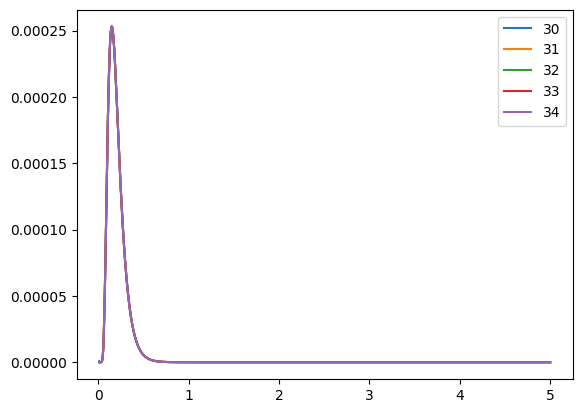

In [31]:
t_pts = np.linspace(0.01, 5, 1000)
k_range = range(30, 35)
for K_max in k_range:
    p_e = [p_E_minus(t, V_E, theta_E, K_max) for t  in t_pts]
    plt.plot(t_pts, p_e)
    
plt.legend([str(k) for k in k_range], loc='upper right');

# Effect of V_A and V_E

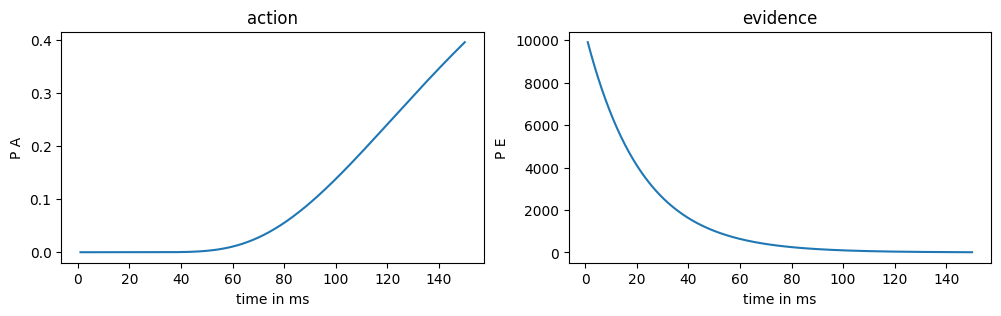

In [125]:
V_A = 0.5; theta_A = 1; 
V_E = 2; theta_E = 5

t_pts = np.linspace(0.001, 0.15, 1000); K_max = 30
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
p_act = [density_A_fn(t, V_A, theta_A) for t in t_pts]
plt.plot(t_pts*1000, p_act); plt.xlabel('time in ms'); plt.ylabel('P A'); plt.title('action')
plt.subplot(1, 2, 2)
p_evid = [density_E_minus_fn(t, V_E, theta_E, K_max) + density_E_minus_fn(t, -V_E, theta_E, K_max) for t in t_pts]
plt.plot(t_pts*1000, p_evid); plt.xlabel('time in ms'); plt.ylabel('P E'); plt.title('evidence');

# Simulation

In [109]:
def simulate_psiam(V_A, theta_A, V_E, theta_E, Z_E=0):
    AI = 0; DV = Z_E; t = 0; dt = 1e-6; dB = dt**0.5
    is_act = 0
    while True:
        DV += V_E*dt + np.random.normal(0, dB)
        AI += V_A*dt + np.random.normal(0, dB)
        t += 1
        
        if DV >= theta_E:
            choice = +1; RT = t*dt
            break
        elif DV <= -theta_E:
            choice = -1; RT = t*dt
            break
        
        if AI >= theta_A:
            is_act = 1
            if DV >= 0:
                choice = 1; RT = t*dt
            else:
                choice = -1; RT = t*dt
            break
        
        

    return choice, RT, is_act

In [126]:
V_A = 0.5; theta_A = 1; 
V_E = 2; theta_E = 5

N_sim = 5000
choices = np.zeros((N_sim, 1)); RTs = np.zeros((N_sim, 1)); is_act_resp = np.zeros((N_sim, 1))


def simulate_wrapper(V_A, theta_A, V_E, theta_E):
    return simulate_psiam(V_A, theta_A, V_E, theta_E)

results = Parallel(n_jobs=-1)(delayed(simulate_wrapper)(V_A, theta_A, V_E, theta_E) for _ in range(N_sim))

choices, RTs, is_act_resp = zip(*results)
choices = np.array(choices).reshape(-1, 1)
RTs = np.array(RTs).reshape(-1, 1)
is_act_resp = np.array(is_act_resp).reshape(-1, 1)

print(f'Num of act resp = {is_act_resp.sum()}/{N_sim}')

Num of act resp = 3784/5000


In [130]:
psiam_data = {'choices': choices, 'RTs': RTs, 'is_act_resp': is_act_resp, 'V_A': V_A, 'theta_A': theta_A, 'V_E': V_E, 'theta_E': theta_E}


with open('psiam_data_5k.pkl', 'wb') as f:
    pickle.dump(psiam_data, f)

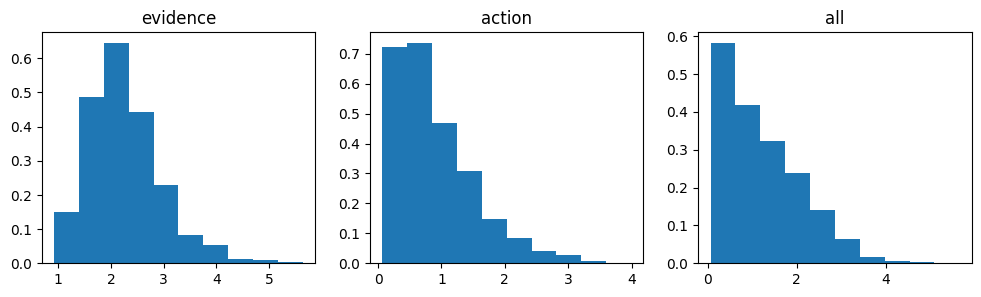

In [131]:
indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid]

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act]

plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.hist(RTs_evid, density=True); plt.title('evidence')
plt.subplot(1,3,2)
plt.hist(RTs_act, density=True); plt.title('action');
plt.subplot(1,3,3)
plt.hist(RTs, density=True); plt.title('all');  

# Fitting

In [2]:
with open('psiam_data_5k.pkl', 'rb') as f:
    psiam_data = pickle.load(f)

In [3]:
# psiam_data = {'choices': choices, 'RTs': RTs, 'is_act_resp': is_act_resp, 'V_A': V_A, 'theta_A': theta_A, 'V_E': V_E, 'theta_E': theta_E}

choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']


In [4]:
indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid]

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act]

# TODO: why this failed?

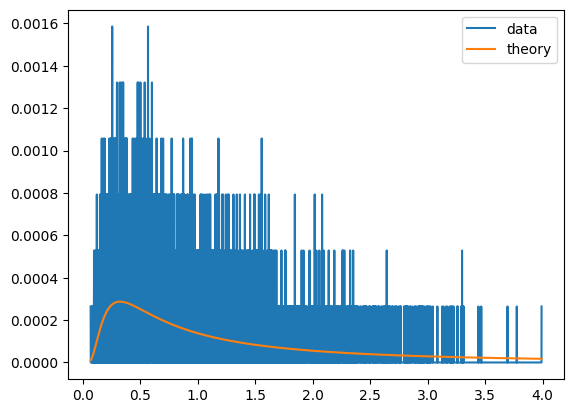

In [5]:
t_pts = np.linspace(min(RTs_act), max(RTs_act), 10000)
p_A_theory = prob_A_fn(t_pts, V_A, theta_A)

t_pts_flat = t_pts.flatten()
RTs_act_flat = RTs_act.flatten()


p_A_data =  calculate_histogram(t_pts_flat, RTs_act_flat)

plt.plot(t_pts[:-1], p_A_data)
plt.plot(t_pts[:-1],p_A_theory);
plt.legend(['data', 'theory'])

# Fitting $P_A$

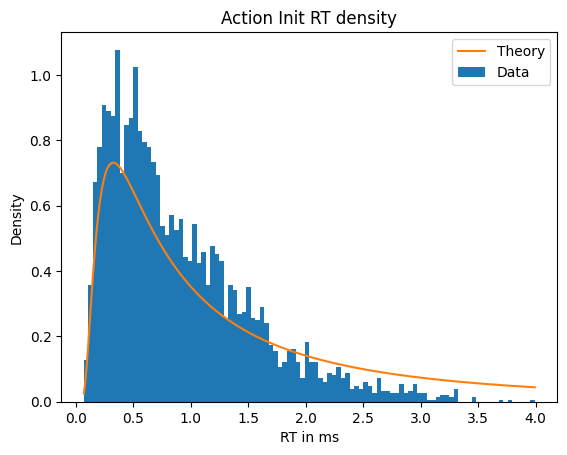

In [23]:
plt.hist(RTs_act_flat, density=True, bins=100);
t_pts = np.linspace(min(RTs_act_flat), max(RTs_act_flat), 500)
density_theory = [density_A_fn(t, V_A, theta_A) for t in t_pts]
plt.plot(t_pts, density_theory);

plt.xlabel('RT in ms'); plt.ylabel('Density')
plt.title('Action Init RT density'); plt.legend(['Theory', 'Data']);

# Fitting $P_E$

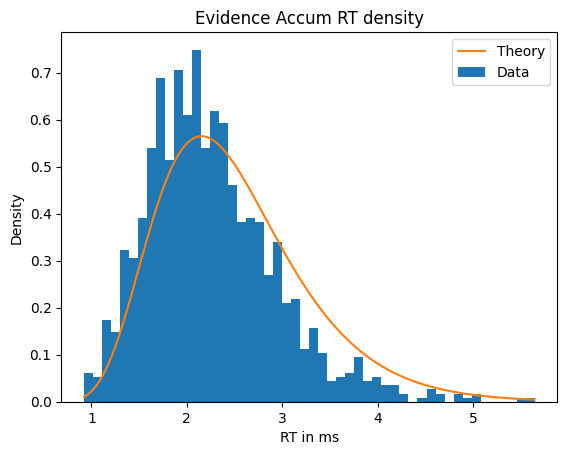

In [22]:
K_max = 50
RTs_evid = RTs_evid.flatten()
plt.hist(RTs_evid, density=True, bins=50);

t_pts = np.linspace(min(RTs_evid), max(RTs_evid), 1000)
density_theory = [density_E_minus_fn(t, V_E, theta_E, K_max) + density_E_minus_fn(t, -V_E, theta_E, K_max) for t in t_pts]

plt.plot(t_pts, density_theory);

plt.xlabel('RT in ms'); plt.ylabel('Density')
plt.title('Evidence Accum RT density'); plt.legend(['Theory', 'Data']);

# Fitting $P_E$ and $P_A$ both

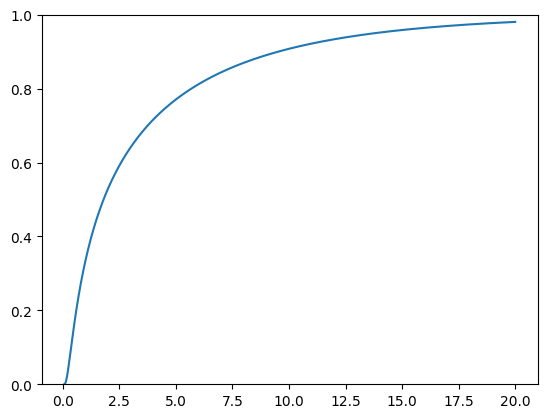

In [5]:
t_pts = np.linspace(min(RTs_act), 20, 1000)
cum_A = [c_A(t, V_A, theta_A) for t in t_pts]

plt.plot(t_pts, cum_A);
plt.ylim(0, 1);

# Analytic integration, Normalization factor is NOT 1

Text(0.5, 1.0, 'Analytic')

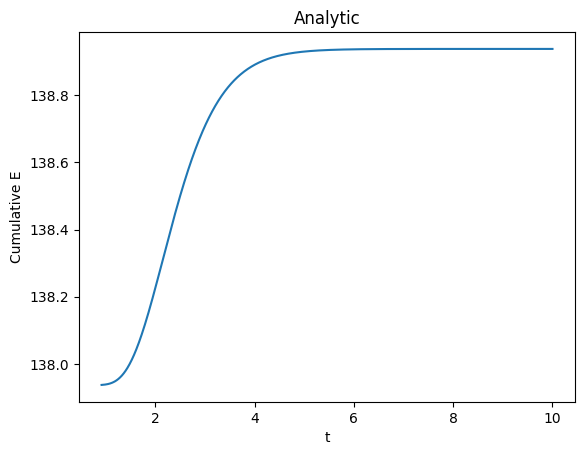

In [9]:
t_pts = np.linspace(min(RTs_evid), 10, 1000)
K_max = 50
cum_E = [c_E_minimal(t, V_E, theta_E, K_max) + c_E_minimal(t, -V_E, theta_E, K_max) for t in t_pts]

plt.plot(t_pts, cum_E);plt.xlabel('t'); plt.ylabel('Cumulative E'); plt.title('Analytic')

Text(0.5, 1.0, 'Numeric')

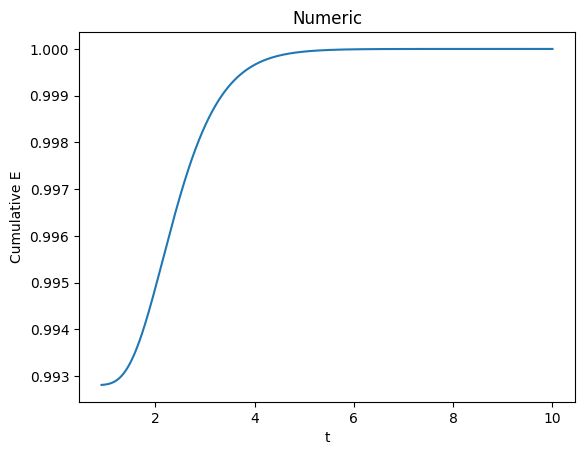

In [5]:
t_pts = np.linspace(min(RTs_evid), 10, 1000)
K_max = 50
cum_E = [cdf_E_both_bounds(t, V_E, theta_E, K_max) for t in t_pts]

plt.plot(t_pts, cum_E); plt.xlabel('t'); plt.ylabel('Cumulative E'); plt.title('Numeric')

# Fitting both

In [6]:
t_pts = np.linspace(min(RTs), max(RTs), 1000)

In [7]:
pt_theory = [density_A_fn(t, V_A, theta_A)*(1 - cdf_E_both_bounds(t, V_E, theta_E, K_max)) + (density_E_minus_fn(t, V_E, theta_E, K_max) + density_E_minus_fn(t, -V_E, theta_E, K_max))*(1 - c_A(t, V_A, theta_A)) for t in t_pts]

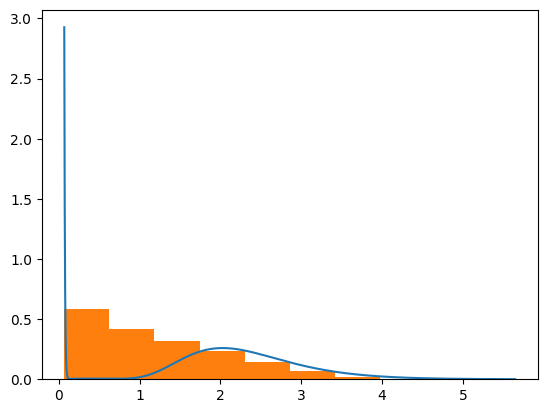

In [10]:
plt.plot(t_pts, pt_theory);
plt.hist(RTs, density=True);